## Transfer learning: use a small pretrained Image classification model on MSCOCO from huggingface to develop a binary classifier for two of the action classes

- **Import required libraries**

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from transformers import CLIPProcessor, CLIPModel
import torch

- **Load dataset and preprocess images and labels**

In [15]:
# Load the dataset
dataset_path = "../data/cs552j_A1_dataset_image_id_url.csv"
df = pd.read_csv(dataset_path)

# Define label mapping
label_mapping = {
    'walking_running': 0,
    'sitting': 1,
    'standing': 2
}

# Convert labels to binary (sitting vs. non-sitting)
def convert_to_binary_label(label):
    numerical_label = label_mapping[label]
    # Convert walking_running and standing to the same class
    # 0 = walking_running/standing, 1 = sitting
    return 1 if numerical_label == 1 else 0

# Add numerical label column
df['numerical_label'] = df['label'].apply(convert_to_binary_label)


- **Image preprocessing function**

In [16]:
def load_and_preprocess_image(file_path):
    try:
        img = Image.open(file_path).convert('RGB')
        img = img.resize((224, 224))
        img_array = np.array(img) / 255.0
        return img_array
    except Exception as e:
        print(f"Error loading image {file_path}: {e}")
        return None

# Load and preprocess all images
images = []
valid_indices = []
labels = []

for idx, row in df.iterrows():
    file_path = os.path.join('../a1_images', row['file_name'])
    img_array = load_and_preprocess_image(file_path)
    
    if img_array is not None:
        images.append(img_array)
        labels.append(row['numerical_label'])
        valid_indices.append(idx)

# Convert to numpy arrays
X = np.array(images)
y = np.array(labels)

# Print dataset statistics
print(f"Total images loaded: {len(X)}")
print(f"Class distribution: {pd.Series(y).value_counts().to_dict()}")

Total images loaded: 285
Class distribution: {0: 190, 1: 95}


- **Split train and test dataset**

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

- **Load pretrained model for binary classifier**

In [19]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add a global average pooling layer to reduce dimensions
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

# Create a feature extractor by removing the last classification layer
feature_extractor = tf.keras.Model(
    inputs=base_model.input,
    outputs=base_model.layers[-4].output
)

- **Train model**

In [ ]:
# Freeze the base model layers to prevent them from being updated during training
for layer in feature_extractor.layers:
    layer.trainable = False

# Extract features for training and test sets
print("Extracting features from images...")
train_features = feature_extractor.predict(X_train)
test_features = feature_extractor.predict(X_test)

# Build a new binary classifier on top of the feature extractor
# Add a Flatten layer at the beginning to convert 4D tensor to 2D
binary_classifier = tf.keras.Sequential([
    tf.keras.layers.Flatten(),  # Add this to flatten the input features
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the binary classifier
binary_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the binary classifier
history = binary_classifier.fit(
    train_features, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Evaluate the model
y_pred_prob = binary_classifier.predict(test_features)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

- **Get model for inference (feature extraction + classification)**

In [29]:
def create_complete_model():
    input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
    features = feature_extractor(input_layer)
    prediction = binary_classifier(features)
    return tf.keras.Model(inputs=input_layer, outputs=prediction)

- **Model metrics**

Test Accuracy: 0.8421

Classification Report:
                          precision    recall  f1-score   support

walking_running/standing       0.84      0.95      0.89        38
                 sitting       0.86      0.63      0.73        19

                accuracy                           0.84        57
               macro avg       0.85      0.79      0.81        57
            weighted avg       0.84      0.84      0.84        57



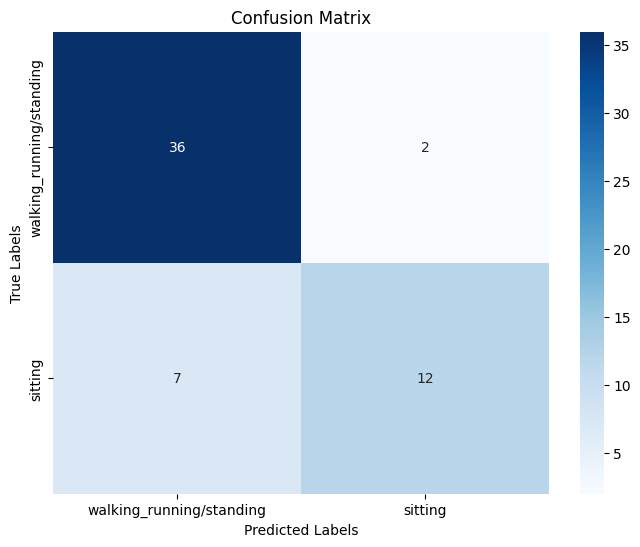

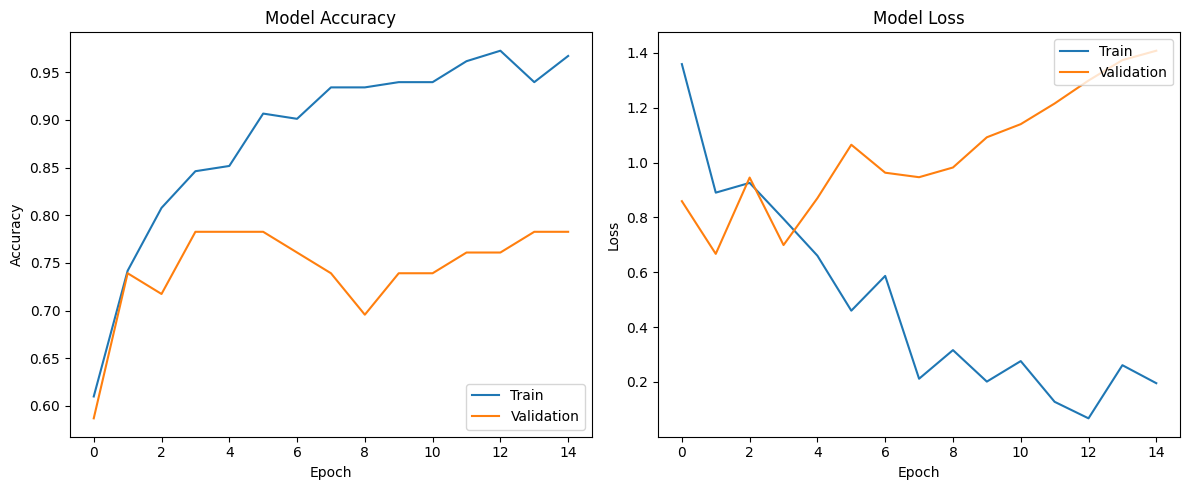

1/1 [==============================] - 1s 805ms/step


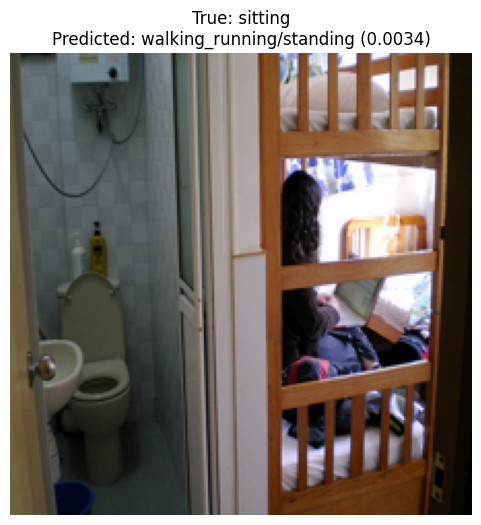

1/1 [==============================] - 0s 82ms/step


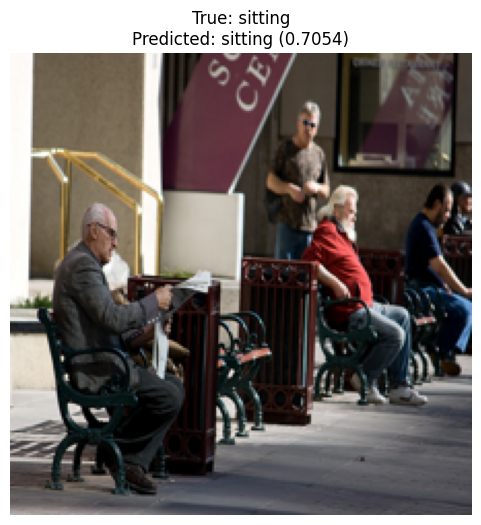

1/1 [==============================] - 0s 88ms/step


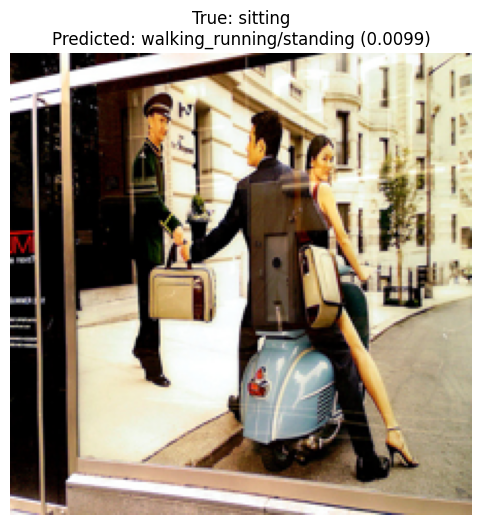

1/1 [==============================] - 0s 82ms/step


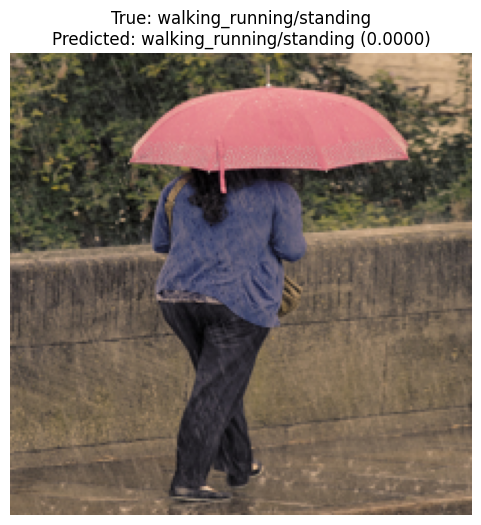

1/1 [==============================] - 0s 69ms/step


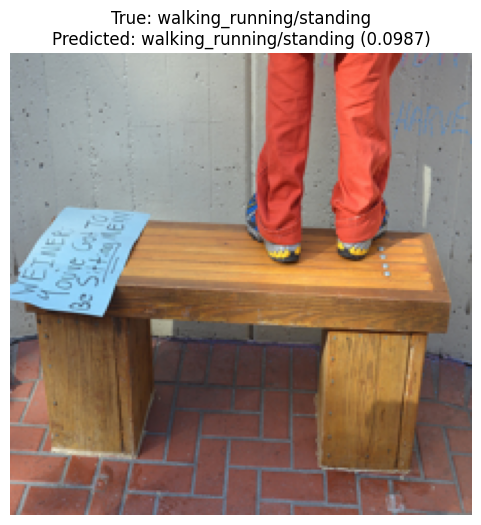

In [36]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
target_names = ['walking_running/standing', 'sitting']
print(classification_report(y_test, y_pred, target_names=target_names))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

complete_model = create_complete_model()

# Test with a few examples
sample_indices = np.random.choice(len(X_test), min(5, len(X_test)), replace=False)
for idx in sample_indices:
    img = X_test[idx]
    true_label = y_test[idx]
    
    # Make prediction
    img_batch = np.expand_dims(img, axis=0)
    prediction = complete_model.predict(img_batch)[0][0]
    pred_label = 1 if prediction > 0.5 else 0
    
    # Display results
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"True: {target_names[true_label]}\nPredicted: {target_names[pred_label]} ({prediction:.4f})")
    plt.axis('off')
    plt.show()

## Multimodal Embeddings

#### **1. Create a simple neural classifier to classify embeddings of the images for their label**
    - Using CLIP

- **Define training and testing sets again to use 3 labels here**

In [34]:
dfn = df.copy()
label_mapping = {
    'walking_running': 0,
    'sitting': 1,
    'standing': 2
}
dfn['numerical_label'] = dfn['label'].apply(lambda x: label_mapping[x])
images = []
valid_indices = []
labels = []

for idx, row in df.iterrows():
    file_path = os.path.join('../a1_images', row['file_name'])
    img_array = load_and_preprocess_image(file_path)
    
    if img_array is not None:
        images.append(img_array)
        labels.append(row['numerical_label'])
        valid_indices.append(idx)

# Convert to numpy arrays
X = np.array(images)
y = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
model_name = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(model_name)
clip_model = CLIPModel.from_pretrained(model_name)

# Function to extract image embeddings
def extract_clip_embeddings(images):
    batch_size = 32
    all_embeddings = []
    
    # Process images in batches to avoid memory issues
    for i in range(0, len(images), batch_size):
        batch_images = images[i:i+batch_size]
        # Convert from numpy arrays to PIL Images for the processor
        pil_images = [Image.fromarray((img * 255).astype(np.uint8)) for img in batch_images]
        
        inputs = processor(images=pil_images, return_tensors="pt", padding=True)
        
        with torch.no_grad():
            outputs = clip_model.get_image_features(**inputs)
            
        embeddings = outputs.cpu().numpy()
        all_embeddings.append(embeddings)
    
    return np.vstack(all_embeddings)

- **Extract embeddings for train and test sets**

In [ ]:
print("Extracting CLIP embeddings for training set...")
train_embeddings = extract_clip_embeddings(X_train)
print("Extracting CLIP embeddings for test set...")
test_embeddings = extract_clip_embeddings(X_test)

- **Build a simple neural classifier on top of CLIP embeddings**

In [ ]:
embedding_classifier = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(train_embeddings.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
embedding_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
embedding_history = embedding_classifier.fit(
    train_embeddings, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Evaluate the model
y_pred_prob = embedding_classifier.predict(test_embeddings)
y_pred_clip = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate accuracy
clip_accuracy = accuracy_score(y_test, y_pred_clip)
print(f"CLIP Embeddings Classifier Accuracy: {clip_accuracy:.4f}")

- **Print classification report**

In [ ]:
target_names = ['walking_running/standing', 'sitting']
print(classification_report(y_test, y_pred_clip, target_names=target_names))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_clip)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - CLIP Embeddings Classifier')
plt.show()

# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(embedding_history.history['accuracy'])
plt.plot(embedding_history.history['val_accuracy'])
plt.title('CLIP Embeddings Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(embedding_history.history['loss'])
plt.plot(embedding_history.history['val_loss'])
plt.title('CLIP Embeddings Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

#### **2. Create a classifier that uses the cosine distance between the embedding of the labels e.g. “reading” as a feature or uses the embedding of the image to derive other useful features**

- **Define text prompts for each class**

In [ ]:
text_prompts = [
    "A photo of a person walking or running",
    "A photo of a person sitting",
    "A photo of a person standing"
]

# Extract text embeddings
def extract_text_embeddings(text_prompts):
    inputs = processor(text=text_prompts, return_tensors="pt", padding=True)
    
    with torch.no_grad():
        outputs = clip_model.get_text_features(**inputs)
        
    return outputs.cpu().numpy()

# Get text embeddings for our classes
text_embeddings = extract_text_embeddings(text_prompts)
print(f"Shape of text embeddings: {text_embeddings.shape}")

- **Create classifier**

In [ ]:
def get_cosine_similarity(image_embeddings, text_embeddings):
    # Normalize embeddings
    normalized_image_embeddings = image_embeddings / np.linalg.norm(image_embeddings, axis=1, keepdims=True)
    normalized_text_embeddings = text_embeddings / np.linalg.norm(text_embeddings, axis=1, keepdims=True)
    
    # Compute similarities for each image with each text prompt
    similarities = np.dot(normalized_image_embeddings, normalized_text_embeddings.T)
    return similarities

# Compute similarities for train and test sets
train_similarities = get_cosine_similarity(train_embeddings, text_embeddings)
test_similarities = get_cosine_similarity(test_embeddings, text_embeddings)

# Create classifier using similarities as features
cosine_classifier = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(train_similarities.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
cosine_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
cosine_history = cosine_classifier.fit(
    train_similarities, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Evaluate the model
cosine_pred_prob = cosine_classifier.predict(test_similarities)
cosine_pred = (cosine_pred_prob > 0.5).astype(int).flatten()

# Calculate accuracy
cosine_accuracy = accuracy_score(y_test, cosine_pred)
print(f"Cosine Similarity Classifier Accuracy: {cosine_accuracy:.4f}")

- **Print classifier report**

In [ ]:
target_names = ['walking_running', 'sitting', 'standing']
print(classification_report(y_test, cosine_pred, target_names=target_names))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, cosine_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Cosine Similarity Classifier')
plt.show()

# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(cosine_history.history['accuracy'])
plt.plot(cosine_history.history['val_accuracy'])
plt.title('Cosine Similarity Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(cosine_history.history['loss'])
plt.plot(cosine_history.history['val_loss'])
plt.title('Cosine Similarity Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

# Compare with other models
print("\nModel Comparison:")
print(f"Transfer Learning Classifier Accuracy: {accuracy:.4f}")
print(f"CLIP Embeddings Classifier Accuracy: {clip_accuracy:.4f}")
print(f"Cosine Similarity Classifier Accuracy: {cosine_accuracy:.4f}")

# Visualize predictions on random samples
sample_indices = np.random.choice(len(X_test), min(5, len(X_test)), replace=False)
for idx in sample_indices:
    img = X_test[idx]
    true_label = y_test[idx]
    
    # Get predictions
    cosine_prediction = cosine_pred[idx]
    
    # Display image and predictions
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"True label: {target_names[true_label]}\n" +
              f"Cosine classifier prediction: {target_names[cosine_prediction]}")
    plt.axis('off')
    plt.show()

# Analyze similarity features
plt.figure(figsize=(10, 6))
class_labels = ['walking/running', 'sitting', 'standing']

# Plot average similarity for each class
for class_idx in range(2):  # Binary classification
    class_mask = y_test == class_idx
    avg_similarities = np.mean(test_similarities[class_mask], axis=0)
    
    plt.bar(
        np.arange(len(class_labels)) + (0.4 * class_idx - 0.2), 
        avg_similarities,
        width=0.4,
        label=f'Class {target_names[class_idx]}'
    )

plt.xlabel('Text Prompt Category')
plt.ylabel('Average Cosine Similarity')
plt.title('Average Similarity Between Images and Text Prompts')
plt.xticks(np.arange(len(class_labels)), class_labels)
plt.legend()
plt.tight_layout()
plt.show()